<a href="https://colab.research.google.com/github/hotdog1029/deeplearning/blob/main/6_MNIST%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_Multi_Layer_Perceptron(MLP)_%EC%84%A4%EA%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Module Import
import numpy as np   #(1)
import matplotlib.pyplot as plt   #(2)
import torch    #(3)
import torch.nn as nn #(4)
import torch.nn.functional as F   #(5)
from torchvision import transforms, datasets    #(6)

(1) 선형 대수와 관련된 함수를 쉽게 이용할 수 있는 모듈로, 대부분 파이썬 코드 스크립트에서 가장 자주 언급된다.

(2) 함수 실행 결과 산출물에 대한 수치를 사람이 쉽게 이해할 수 있도록 시각화할 수 있는 외부 모듈이다.

(3) 우리가 이용하는 딥러닝 프레임워크 중 하나인 파이토치의 기본 모듈이다.

(4) 파이토치 모듈 중 딥러닝, 즉 인공 신경망 모델을 설계할 때 필요한 함수를 모아놓은 모듈이다.

(5) 'torch.nn' 모듈 중에서도 가장 자주 이용되는 함수를 'F'로 지정

(6) 컴퓨터 비전 연구 분야에서 자주 이용하는 'torchvision' 모듈 내 'transforms', 'datasets' 함수를 임포트한다.

In [ ]:
# 2. 딥러닝 모델을 설계할 때 활용되는 장비 확인
if torch.cuda.is_available():     #(7)
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)

BATCH_SIZE = 32   #(8)
EPOCHS = 10   #(9)

Using PyTorch version:  1.7.0+cu101 Device:  cpu


(7) 파이토치 프레임워크를 이용해 딥러닝 모델을 설계할 때나 딥러닝 모델을 구성하고 있는 파라미터 값을 업데이트할 때 이용하는 장비를 선택할 수 있다. 만약 CUDA에서 GPU를 이욯하고 있다면 'cuda', 이용하지 않고 있다면 'cpu'로 설정된다. 만약 GPU를 이용하고 있다면 계산속도가 빠르기 때문에 딥러닝 모델의 파라미터 값을 빠르게 업데이트 할 수 있다. 이 예제를 실행하는 환경에서 현재 이용하고 있는 파이토치는 1.7버전이다.

(8) BATCH_SIZE는 MLP 모델을 학습할 때 필요한 데이터 개수의 단위이다. Mini-Batch 1개 단위에 대해 데이터가 32개로 구성돼 있는 것을 의미한다. MLP 모델을 학습할 때 32개의 데이터를 이용해 첫 번째로 학습하고 그 다음 32개의 데이터를 이용해 두 번째로 학습한다. 이 과정을 마지막 데이터까지 반복해 학습을 진행한다. 1개의 Mini-Batch를 이용해 학습하는 횟수를 'Iteration', 전체 데이터를 이용해 학습을 진행한 회수를 Epoch라 한다.

(9) 전체 데이터셋을 10번 반복해 학습한다는 것을 의미한다.

In [ ]:
# 3. MNIST 데이터 다운로드(Train set, Test set 분리하기)
train_dataset = datasets.MNIST(root = '../data/MNIST',    # (10)
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = '../data/MNIST',    # (11)
                               train = False,
                               transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,   # (12)
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = train_dataset,    # (13)
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

(10),(11) MNIST 데이터셋을 다운로드 한다.

root: 데이터가 저장될 잘소를 지정한다. 여기서 '../'은 상위 폴더를 의미한다. 이 예제에서는 코드가 실행되는 디렉터리의 상위 디렉터리에 존재하는 data 폴더 내 MNIST 폴더에 저장하는 내용이다.

train: 대상 데이터가 MLP 모델을 학습하기 위해 이용하는 학습용 데이터인지, MLP모델의 학습된 이후 성능을 검증하기 위한 검즈용 데이터인지를 지정한다. 'train =True'로 표기한 데이터는 학습용 데이터셋인 'train_dataset'으로 설정하며 'train = False로 표기한 데이터는 검증용 데이터셋인 'test_dataset'으로 설정한다.

download: 해당 데이터를 인터넷상에서 다운로드해 이용할 것인지를 지정한다.

transform: 사람의 손글씨 데이터인 MNIST는 이미지 데이터이다. 데이터를 다운할 때 이미지 데이터에 대한 기본적인 전처리를 동시에 진행할 수 있다. 여기서는 'torch' 모듈로 설계한 MLP의 input으로 이용되기 때문에 'ToTensor()'메서드를 이용해 tensor 형태로 변경한다. 또한 한 픽셀은 0 ~ 255 범위의 스칼라 값으로 구성돼 있는데, 이를 0~1 범위에서 정규화 과정이 진행된다. MLP 모델이 포함된 인공 신경망 모델은 Input 데이터 값의 크기가 커질수록 불안정하거나 과적합되는 방향으로 학습이 진행될 우려가 있기 때문에 정규화 과정을 이용해 input으로 이용하는 것을 권장한다.

(12) (13) 다운로드한 MNIST 데이터셋을 Mini-Batch 단위로 분리해 지정한다. 여기서는 Mini-Batch 단위를 이용해 MLP 모델을 학습시킬 것이므로 Mini-Batch별로 데이터를 묶어 단위를 맞추고자 한다. 이미지 데이터 1개는 각각을 이용해 MLP 모델을 학습시키는 것이 아니라 이미지 데이터를 Batch Size만큼, 즉 32개만큼 묶어 1개의 Mini-Batch를 구성하는 것을 'DataLoader' 함수를 이용해 진행할 수 있다.

dataset: Mini-Batch 단위로 할당하고자 하는 데이터셋을 지정한다.

batch_size: Mini-Batch 1개 단위를 구성하는 데이터의 개수를 지정한다. 이 예제에서는 이미 BATCH_SIZE = 32 로 지정했다.

shuffle: 데이터의 순서를 섞고자 할 때 이용한다.

In [ ]:
# 4. 데이터 확인하기 (1)
for(x_train, y_train) in train_loader:    #(14)
  print('x_train:', x_train.size(), 'type: ', x_train.type())
  print('y_train:', y_train.size(), 'type: ', y_train.type())
  break

x_train: torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train: torch.Size([32]) type:  torch.LongTensor


(14) 다운로드한 후 Mini-Batch 단위로 할당한 데이터의 개수와 형태를 확인한다.

x_train: 32개의 이미지 데이터가 1개의 Mini-Batch를 구성하고 있고 가로 28개, 세로 28개의 픽셀로 구성돼 있으며 채널이 1이므로 그레이스케일로 이뤄진, 다시 말해 흑백으로 이뤄진 이미지 데이터라는 것을 확인할 수 있다.

y_train: 32개의 이미지 데이터 각각에 label 값이 1개씩 존재하기 때문에 32개의 값을 갖고 있다는 것을 확인할 수 있다.

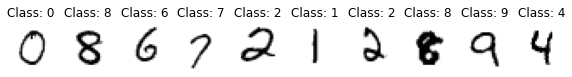

In [ ]:
# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize =(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28), cmap = 'gray_r')
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
# 6. MLP 모델 설계하기
class Net(nn.Module):   # (15)
  def __init__(self):   # (16)
    super(Net,self).__init__()    # (17)
    self.fc1 = nn.Linear(28 * 28, 512)    # (18)
    self.fc2 = nn.Linear(512, 256)    # (19)
    self.fc3 = nn.Linear(256, 10)   # (20)
  def forward(self, x):   # (21)
    x = x.view(-1, 28 * 28)   # (22)
    x = self.fc1(x)   # (23)
    x = F.sigmold(x)    # (24)
    x = self.fc2(x)   # (25)
    x = F.sigmold(x)    # (26)
    x = self.fc3(x)   # (27)
    x = F.log_softmax(x, dim = 1)   # (28)
    return x

(15) 파이토치 모듈 내에 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스를 정의한다. nn.Module 클래스를 상속받았을 때 nn.Moldule 클래스가 이용할 수 있는 함수를 그대로 이용할 수 있기 때문에 새로운 딥러닝 모델을 설계 할 때 자주 이용된다.

(16) Net 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 메서드이다.

(17) nn.Module 내에 있는 메서드를 상속받아 이용한다.

(18) 첫 번째 Fully Connected Layer를 정의한다. MNIST 데이터를 input으로 사용하기 위해 28 * 28 * 1 (가로 * 세로 * 채널 수 ) 크기의 노드 수를 설정한 후 두 번째 Fully Connected Layer의 노드 수를 512개로 설정할 것이기 때문에 output의 노드 수는 512개로 설정한다.

(19) 두 번째 Fully Connected Layer를 정의한다. 첫 번째 Fully Connected Layer의 output 크기인 512 크기의 벡터 값을 input으로 사용하기 위해 노드 수를 512개로 설정하고 세 번째 Fully Connected Layer의 노드 수를 256으로 설정할 것이기 때문에 output의 노드 수를 256개로 설정한다.

(20) 세 번째 Fully Connected Layer를 정의한다. 두 번째 Fully Connected Layer의 output 크기인 256 크기의 벡터 값을 input으로 사용하기 위한 노드 수를 256개, output으로 사용하기 위한 노드 수를 10개로 설정한다. 0부터9까지 총 10가지 클래스를 표현하기 위한 Label 값은 원-핫 인코딩으로 표현된다. MLP 모델의 output 값과 loss를 계산하려면 이에 맞는 크기의 벡터를 계산해야 한다. 따라서 output의 노드 수를 10개로 정의한다.

(21) Net 클래스를 이용해 설계한 MLP 모델의 Forward Propagation을 정의한다. 즉, 설계한 MLP 모델에 데이터를 입력했을 때 output을 계산하기까지의 과정을 나열한 것이다.

(22) MLP모델은 1차원 벡터 값을 입력으로 받을 수 있다. 하지만 MNIST 이미지 데이터는 크기가 28 * 28 인 2차원 데이터이다. 따라서 2차원 데이터를 1차원 데이터로 변환하려면 View 메서드를 이용해 784 크기의 1차원 데이터로 변환해 진행해야 한다. 이를 '2차원의 데이터를 1차원으로 펼친다'리고 표현한다.

(23) __init__() 매서드를 이용해 정의한 첫 번째 Fully Connected Layer에 1차원으로 펼친 이미지를 통과시킨다.

(24) 파이토치 모듈 중 인공 신경망 설계에 유용한 함수를 모아 놓은 torch.nn.functional 내에 정의된 비선형 함수인 sigmoid()를 이용해 두 번째 Fully Connected Layer의 input으로 계산한다.

(25) __init__() 매서드를 이용해 정의한 두 번째 Fully Connected Layer에 (24)에서 시그모이드 함수를 이용해 계산된 결과값을 통과시킨다.

(26) 파이토치 모듈 중 인공 신경망 설계에 유용한 함수를 모아 놓은 torch.nn.functional 내에 정의된 비선형 함수인 sigmoid()를 이용해 세 번째 Fully Connected Layer의 input으로 계산한다

(27) __init__() 매서드를 이용해 정의한 세 번째 Fully Connected Layer에 (25)에서 시그모이드 함수를 이용해 계산된 결과값을 통과시킨다.

(28) 파이토치 모듈 중 torch.nn.functional 내의 log.softmax()를 이용해 최종 output을 계산한다. 0부터 9까지, 총 10가지 경우의 수 중 하나로 분류하는 일을 수행하기 때문에 softmax를 이용해 확률 값을 계산한다. 일반적인 softmax가 아닌 log_softmax()를 이용하는 이유는 MLP 모델이 Back Propagation 알고리즘을 이용해 학습을 진행할 때 loss 값에 대한 Gradient 값을 좀 더 원할하게 계산할 수 있기 때문이다.

In [ ]:
# 7. Optimizer, Objective Function 설정하기
model = Net().to(DEVICE)    # (29)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)    # (30)
criterion = nn.CrossEntropyLoss()   # (31)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


(29) 6.MLP 모델 설계하기에서 정의한 MLP모델을 기존에 선정한 'DEVICE'에 할당한다. 그 이유는 'DEVICE' 장비를 이용해 MLP모델을 완성하기 위해서이다.

(30) Bcak Propagation을 이용해 파라미터를 업데이트할 때 이용하는 Optimizer를 정의한다. 이 예제에서는 SGD 알고리즘을 이용하여 파라미터를 업데이트할 때 반영될 lr을 0.01, optimizer의 관성을 나타내는 momentum을 0.5로 설정하였다.

(31) MLP 모델의 output 값과 계산될 Label 값은 Class를 표현하는 원-핫 인코딩 값이다. MLP 모델의 output 값과 원-핫 인코딩 값과의 loss는 crossentropy를 이용해 계산한다.

In [ ]:
# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()   # (32)
  for batch_idx,(image,label) in enumerate(train_loader):   # (33)
    image = image.to(DEVICE)    # (34)
    label = label.to(DEVICE)    # (35)
    optimizer.zero_grad()   # (36)
    output = model(image)   # (37)
    loss = criterion(output,label)    # (38)
    loss.backward()   # (39)
    optimizer.step()    # (40)

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'. format( 
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

(32) 기존에 정의한 MLP 모델을 학습 상태로 지정한다.

(33) 기존에 정의한 train_loder에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 Mini-batch 단위로 묶여 저장돼 있다. 해당 'train_loder'내에 Mini-batch 단위로 저장된 데이터를 순서대로 이용해 MLP 모형을 학습시킨다.

(34) (35) Mini-batch 내에 있는 데이터를 이용해 MLP 모델을 학습시키기 위해 기존에 정의한 장비를 할당한다.

(36) Mini-batch 내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 loss의 gradient 값이 optimizer에 할당돼 있으므로 optimizer의 gradient를 초기화 한다.

(37) 장비에 할당한 이미지 데이터를 MLP 모델의 input으로 이용해 output을 계산한다.

(38) 계산된 output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 loss 값을 계산한다.

(39) loss 값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradient 값을 각 파라미터에 할당한다.

(40) 각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값을 업데이트한다.

In [ ]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()    # (41)
  test_loss = 0   # (42)
  corrcet = 0   # (43)

  with torch.no_grad():   # (44)
    for image, label in test_loader:    # (45)
      image = image.to(DEVICE)    # (46)
      label = label.to(DEVICE)    # (47)
      output = model(image)   # (48)
      test_loss += criterion(output, label).item()    # (49)
      prediction = output.max(1, keepdim = True)[1]   # (50)
      correct += prediction.eq(label.view_as(prediction)),sum().item()    # (51)
    
    test_loss /= len(test_loader.dataset)   # (52)
    test_accuracy = 100. * correct / len(test_loader.dataset)   # (53)
    return test_loss, test_accuracy   # (54)

(41) 학습 과정 또는 학습이 완료된 MLP 모델을 학습상태가 아닌, 평가 상태로 지정한다.

(42) 기존에 정의한 test_loader 내의 데이터를 이용해 loss 값을 계산하기 위해 test_loss를 0으로 임시 설정한다.

(43) correct = 0으로 임시 설정

(44) MLP 모델을 평가하는 단계에서는 Gradient를 통해 파라미터 값이 업데이터되는 현상을 방지하기 위해 torch.no_grad() 메서드를 이용해 Gradient의 흐름을 억제한다

(45) 기존에 정의한 test_loader 내의 데이터도 train_loader 와 동일하게 미니배치 단위로 저장돼 있다. 미니배치 내에 있는 이미지 데잍와 레이블 데이터에 반복문을 이용해 차례대로 접근한다.

(46) (47) 미니배치 내에 있는 이미지 데이터를 이용해 MLP 모델을 검증하기 위해 기존에 정의한 장비를 할당한다.

(48) 장비에 할당된 이미지 데이터를 MLP 모델의 input으로 output을 계산한다.

(49) 계산된 output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 loss 값을 계산한 결과값을 test_loss 에 더해 업데이트한다.

(50) MLP 모델의 output 값은 크기가 10인 벡터 값이다. 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치을 대응하는 클래스로 예측했다고 판단함

(51) MLP 모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수를 저장한다.

(52) 현재까지 계산된 test_loss의 값을 test_loader 내에 존재하는 미니배치 개수만큼 나눠 평균 loss 값으로 계산한다.

(53) test_loader 데이터 중 얼마나 맞췄는지를 계산해 정확도를 계산한다.

(54) 계산된 값을 반환

In [ ]:
# 10 MLP 학습 실행
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n'.
        format(Epoch, test_loss, test_accuracy))

train 함수와 evaluate함수를 올바르게 정의했다면 정의한 함수를 이용해 MLP 모델을 학습시키거나 검증해보는 과정을 진행한다. 전체 데이터를 이용해 학습하는 횟수를 의미하는 Epoch을 10으로 설정했기 때문에 10번의 학습을 진행하고 학습 과정 속에서 업데이트한 파라미터 값을 바탕으로 MLP 모델의 output이 변화하며 각 Iteration, Epochekd Loss 값이 출력되도록 설정하였다.

Using PyTorch version:  1.7.0+cu101 Device:  cpu
x_train: torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train: torch.Size([32]) type:  torch.LongTensor
Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.278406


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.297929
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.315626
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 2.305398
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 2.262499
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 2.280139
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 2.271647
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 2.329014
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 2.298393
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 2.223814

[EPOCH: 1], 	Test Loss: 0.0698, 	Test Accuracy: 16.83 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 2.216653
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 2.216860
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 2.138975
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 2.101068
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 1.978908
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 1.866670
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 1.759726
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 1.341106
Train Epoch: 2

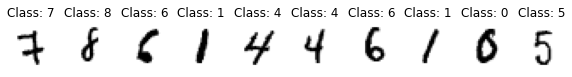

In [ ]:
# 1. Module Import
import numpy as np   #(1)
import matplotlib.pyplot as plt   #(2)
import torch    #(3)
import torch.nn as nn #(4)
import torch.nn.functional as F   #(5)
from torchvision import transforms, datasets    #(6)

# 2. 딥러닝 모델을 설계할 때 활용되는 장비 확인
if torch.cuda.is_available():     #(7)
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)

BATCH_SIZE = 32   #(8)
EPOCHS = 10   #(9)

# 3. MNIST 데이터 다운로드(Train set, Test set 분리하기)
train_dataset = datasets.MNIST(root = '../data/MNIST',    # (10)
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = '../data/MNIST',    # (11)
                               train = False,
                               transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,   # (12)
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = train_dataset,    # (13)
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

# 4. 데이터 확인하기 (1)
for(x_train, y_train) in train_loader:    #(14)
  print('x_train:', x_train.size(), 'type: ', x_train.type())
  print('y_train:', y_train.size(), 'type: ', y_train.type())
  break

# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize =(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28), cmap = 'gray_r')
  plt.title('Class: ' + str(y_train[i].item()))

# 6. MLP 모델 설계하기
class Net(nn.Module):   # (15)
  def __init__(self):   # (16)
    super(Net, self).__init__()    # (17)
    self.fc1 = nn.Linear(28 * 28, 512)    # (18)
    self.fc2 = nn.Linear(512, 256)    # (19)
    self.fc3 = nn.Linear(256, 10)   # (20)

  def forward(self, x):   # (21)
    x = x.view(-1, 28 * 28)   # (22)
    x = self.fc1(x)   # (23)
    x = F.sigmoid(x)    # (24)
    x = self.fc2(x)   # (25)
    x = F.sigmoid(x)    # (26)
    x = self.fc3(x)   # (27)
    x = F.log_softmax(x, dim = 1)   # (28)
    return x

# 7. Optimizer, Objective Function 설정하기
model = Net().to(DEVICE)    # (29)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)    # (30)
criterion = nn.CrossEntropyLoss()   # (31)

print(model)

# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()   # (32)
  for batch_idx,(image,label) in enumerate(train_loader):   # (33)
    image = image.to(DEVICE)    # (34)
    label = label.to(DEVICE)    # (35)
    optimizer.zero_grad()   # (36)
    output = model(image)   # (37)
    loss = criterion(output,label)    # (38)
    loss.backward()   # (39)
    optimizer.step()    # (40)

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'. format( 
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))
      
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()    # (41)
  test_loss = 0   # (42)
  correct = 0   # (43)

  with torch.no_grad():   # (44)
    for image, label in test_loader:    # (45)
      image = image.to(DEVICE)    # (46)
      label = label.to(DEVICE)    # (47)
      output = model(image)   # (48)
      test_loss += criterion(output, label).item()    # (49)
      prediction = output.max(1, keepdim = True)[1]   # (50)
      correct += prediction.eq(label.view_as(prediction)).sum().item()    # (51)
    
    test_loss /= len(test_loader.dataset)   # (52)
    test_accuracy = 100. * correct / len(test_loader.dataset)   # (53)
    return test_loss, test_accuracy   # (54)

# 10 MLP 학습 실행
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n'.
        format(Epoch, test_loss, test_accuracy))

Epoch가 증가할수록 Loss는 줄어들고 Accuracy는 증가하는 것을 볼 수 있다.